In [10]:
import duckdb
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [11]:
con = duckdb.connect()

project_root = Path.cwd().parent
games_path = project_root/"out"/"cleaned_games"

In [12]:
query = f"""
CREATE OR REPLACE VIEW games_clean AS
SELECT *
FROM parquet_scan('{games_path}/*.parquet')
"""

con.execute(query)

## Opening Success by Rating

Analyzing win rates and draw rates for the three main first moves: 1.e4, 1.d4, 1.c4

In [13]:
binsize = 50

query = f"""
WITH opening_games AS (
  SELECT
    CASE
      WHEN moves_san LIKE 'e4 %' THEN '1.e4'
      WHEN moves_san LIKE 'd4 %' THEN '1.d4'
      WHEN moves_san LIKE 'c4 %' THEN '1.c4'
    END AS first_move,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    result
  FROM games_clean
  WHERE moves_san LIKE 'e4 %'
     OR moves_san LIKE 'd4 %'
     OR moves_san LIKE 'c4 %'
)
SELECT
  first_move,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(CASE WHEN result = '1-0' THEN 1 ELSE 0 END) AS white_wins,
  SUM(CASE WHEN result = '0-1' THEN 1 ELSE 0 END) AS black_wins,
  SUM(CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END) AS draws
FROM opening_games
GROUP BY first_move, elo_bin
ORDER BY first_move, elo_bin
"""

df = con.execute(query).fetchdf()
df.head(20)

,first_move,elo_bin,total_games,white_wins,black_wins,draws
0,1.c4,400,2,0.0,1.0,1.0
1,1.c4,450,16,8.0,8.0,0.0
2,1.c4,500,43,20.0,22.0,1.0
3,1.c4,550,54,23.0,26.0,5.0
4,1.c4,600,105,53.0,48.0,4.0
5,1.c4,650,162,71.0,87.0,4.0
6,1.c4,700,302,159.0,133.0,10.0
7,1.c4,750,469,212.0,238.0,19.0
8,1.c4,800,742,359.0,350.0,33.0
9,1.c4,850,1049,515.0,503.0,31.0


In [14]:
# Calculate win and draw percentages
df['white_win_pct'] = 100.0 * df['white_wins'] / df['total_games']
df['draw_pct'] = 100.0 * df['draws'] / df['total_games']

# Apply smoothing
rolling_bins = 10
min_games_per_bin = 100

def weighted_smooth_group(g, column, window=rolling_bins):
    g = g.sort_values('elo_bin').reset_index(drop=True)
    rate = g[column]
    n = g['total_games']
    
    # Get the raw counts for the column (e.g., white_wins, draws)
    if column == 'white_win_pct':
        counts = g['white_wins']
    elif column == 'draw_pct':
        counts = g['draws']
    else:
        counts = rate * n / 100.0
    
    num = counts.rolling(window=window, center=True, min_periods=1).sum()
    denom = n.rolling(window=window, center=True, min_periods=1).sum()
    g[f'{column}_smooth'] = 100.0 * num / denom
    return g

df = df.groupby('first_move', group_keys=False).apply(lambda g: weighted_smooth_group(g, 'white_win_pct'))
df = df.groupby('first_move', group_keys=False).apply(lambda g: weighted_smooth_group(g, 'draw_pct'))

# Filter out bins with too few games
df_plot = df[df['total_games'] >= min_games_per_bin]

selected_openings = ['1.e4', '1.d4', '1.c4']

C:\Users\sebeg\AppData\Local\Temp\ipykernel_25132\1564324023.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('first_move', group_keys=False).apply(lambda g: weighted_smooth_group(g, 'white_win_pct'))
C:\Users\sebeg\AppData\Local\Temp\ipykernel_25132\1564324023.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('first_move', group_keys=False).apply(lambda g: weighted_smooth_group

## White Win % vs Elo by Opening

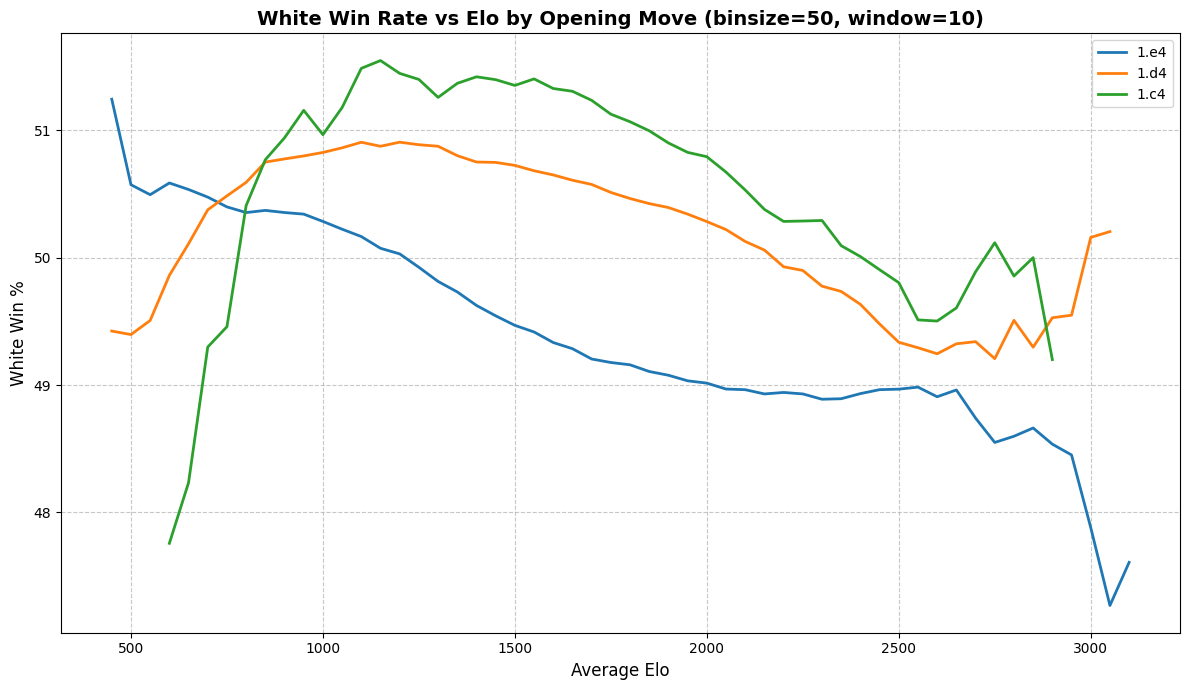

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))

colours = {
    '1.e4': "#1f77b4",
    '1.d4': "#ff7f0e",
    '1.c4': "#2ca02c",
}

for opening in selected_openings:
    g = df_plot[df_plot['first_move'] == opening].sort_values('elo_bin')
    if g.empty:
        continue
    
    ax.plot(
        g['elo_bin'],
        g['white_win_pct_smooth'],
        label=opening,
        linewidth=2,
        color=colours.get(opening, 'k')
    )

ax.set_xlabel('Average Elo', fontsize=12)
ax.set_ylabel('White Win %', fontsize=12)
ax.set_title(f'White Win Rate vs Elo by Opening Move (binsize={binsize}, window={rolling_bins})', fontsize=14, weight='bold')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

## Draw % vs Elo by Opening

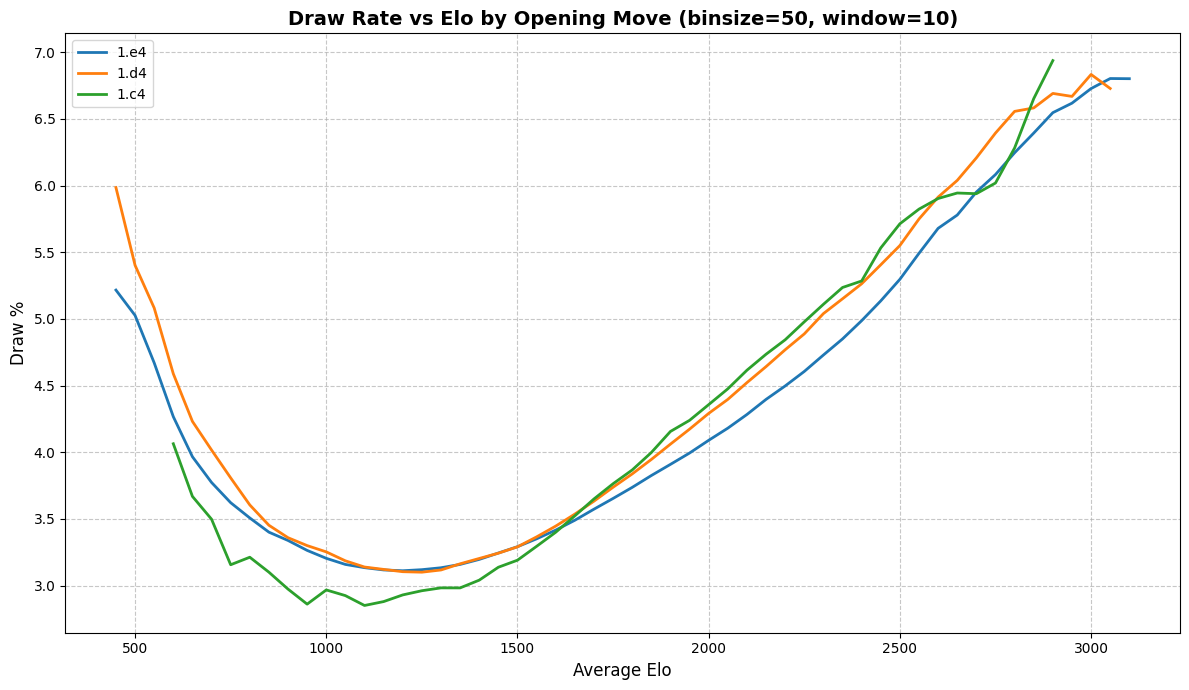

In [16]:
fig, ax = plt.subplots(figsize=(12, 7))

for opening in selected_openings:
    g = df_plot[df_plot['first_move'] == opening].sort_values('elo_bin')
    if g.empty:
        continue
    
    ax.plot(
        g['elo_bin'],
        g['draw_pct_smooth'],
        label=opening,
        linewidth=2,
        color=colours.get(opening, 'k')
    )

ax.set_xlabel('Average Elo', fontsize=12)
ax.set_ylabel('Draw %', fontsize=12)
ax.set_title(f'Draw Rate vs Elo by Opening Move (binsize={binsize}, window={rolling_bins})', fontsize=14, weight='bold')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

In [17]:
con.close()